<a href="https://colab.research.google.com/github/sandipautane/session07/blob/main/experiment-one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print("CIFAR-10 datasets loaded and dataloaders created.")

100%|██████████| 170M/170M [00:06<00:00, 24.4MB/s]


CIFAR-10 datasets loaded and dataloaders created.


The CIFAR-10 dataset is a collection of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The 10 different classes represent airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

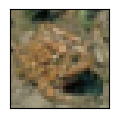

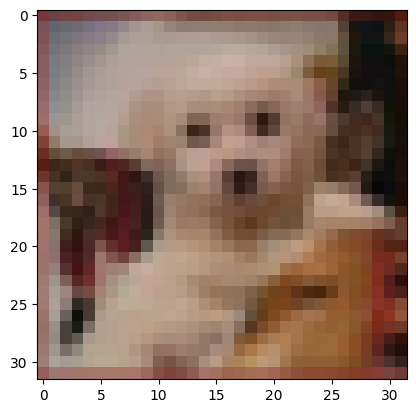

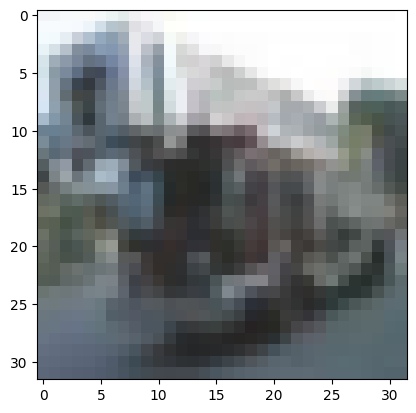

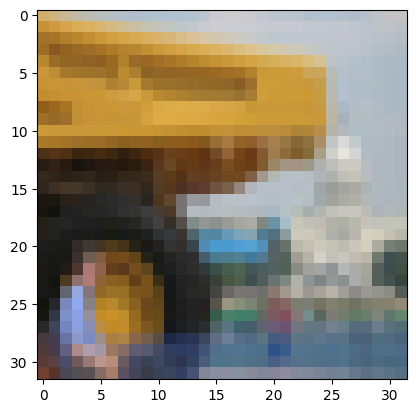

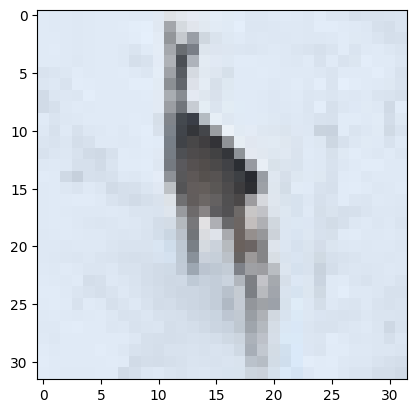

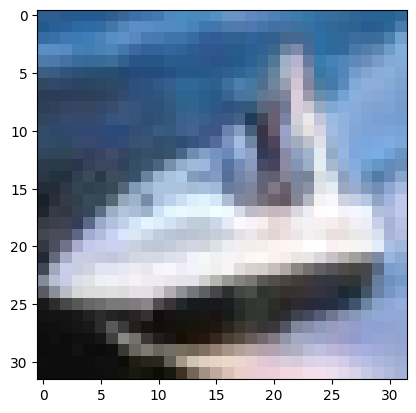

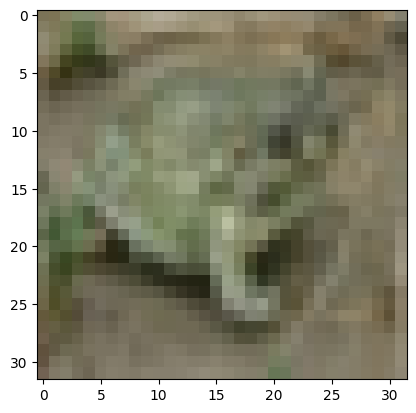

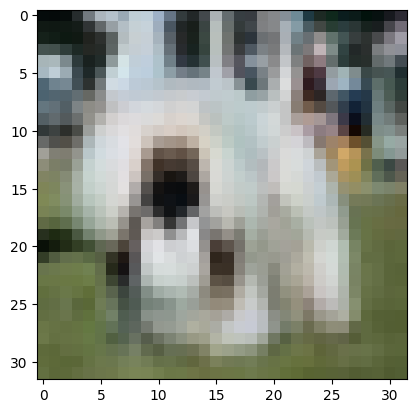

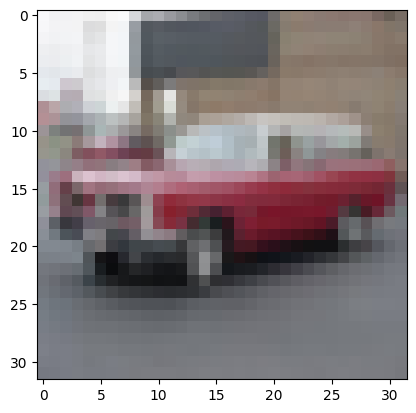

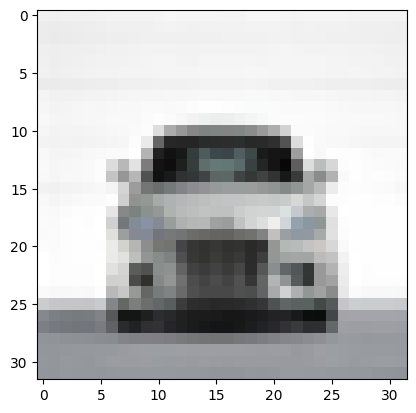

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show 10 images
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(trainset.classes[labels[i]])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Using dilated convolutions to increase receptive field without max pooling or stride
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1) # RF=3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2, dilation=2) # RF = 3 + 2 * (3-1) = 7 -> RF = 3 + 2*(3-1) = 7
        self.conv3 = nn.Conv2d(64, 128, 3, padding=4, dilation=4) # RF = 7 + 4 * (3-1) = 15
        self.conv4 = nn.Conv2d(128, 256, 3, padding=8, dilation=8) # RF = 15 + 8 * (3-1) = 31
        self.conv5 = nn.Conv2d(256, 512, 3, padding=16, dilation=16) # RF = 31 + 16 * (3-1) = 63 -> This makes the receptive field too large. Let's adjust dilation and padding to get closer to 44.

        # Recalculating with adjusted dilations to target RF ~ 44
        # conv1: RF = 3 (k=3, d=1)
        # conv2: RF = 3 + 1*(3-1) + 1*(3-1)*(1) = 7 (k=3, d=2 after conv1)
        # conv3: RF = 7 + 1*(3-1) + 1*(3-1)*(2) = 15 (k=3, d=4 after conv2)
        # conv4: RF = 15 + 1*(3-1) + 1*(3-1)*(4) = 31 (k=3, d=8 after conv3)
        # conv5: RF = 31 + 1*(3-1) + 1*(3-1)*(8) = 63 (k=3, d=16 after conv4)

        # Let's try smaller increments in dilation
        # conv1: RF = 3 (k=3, d=1, p=1)
        # conv2: RF = 3 + 1*(3-1) + 1*(3-1)*(1) = 7 (k=3, d=2, p=2)
        # conv3: RF = 7 + 1*(3-1) + 1*(3-1)*(2) = 15 (k=3, d=4, p=4)
        # conv4: RF = 15 + 1*(3-1) + 1*(3-1)*(4) = 31 (k=3, d=8, p=8)
        # conv5: Need RF increase of ~13. A kernel of 3 with dilation 6 would give 12. A kernel of 3 with dilation 7 would give 14. Let's try dilation 6.
        # conv5: RF = 31 + 1*(3-1) + 1*(3-1)*(8) = 31 + 2 + 16 = 49 with d=8? Receptive field formula for dilated convolution: RF_out = RF_in + (k-1)*d. For sequential layers: RF_total = RF_layerN + (k_layerN-1)*d_layerN * stride_layerN. If no stride, then it's RF_total = RF_layerN + (k_layerN-1)*d_layerN.

        # Let's calculate step by step
        # conv1: k=3, d=1, RF=3
        # conv2: k=3, d=1, RF= 3 + (3-1)*1 = 5. With d=2: RF = 3 + (3-1)*2 = 7
        # conv3: k=3, d=1, RF = 7 + (3-1)*1 = 9. With d=4: RF = 7 + (3-1)*4 = 15
        # conv4: k=3, d=1, RF = 15 + (3-1)*1 = 17. With d=8: RF = 15 + (3-1)*8 = 31
        # conv5: k=3, d=1, RF = 31 + (3-1)*1 = 33. We need ~11 more. (k-1)*d = 11 -> 2*d = 11 -> d=5.5. Let's try d=5.
        # conv5: RF = 31 + (3-1)*5 = 31 + 10 = 41. Close! Let's try d=6.
        # conv5: RF = 31 + (3-1)*6 = 31 + 12 = 43. Very close! Let's stick with these dilation rates.

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1) # RF=3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, dilation=1) # RF=5
        self.conv3 = nn.Conv2d(64, 128, 3, padding=2, dilation=2) # RF= 5 + (3-1)*2 = 9. Wait, the RF calculation is tricky with multiple dilated layers.

        # Let's recalculate RF for sequential dilated layers with kernel size k and dilation d: RF_new = RF_old + (k-1)*d_new * product of strides of previous layers.
        # If stride is always 1, RF_new = RF_old + (k-1)*d_new

        # Receptive field calculation for sequential dilated convolutions (stride=1):
        # RF_1 = k_1
        # RF_2 = RF_1 + (k_2-1)*d_2
        # RF_3 = RF_2 + (k_3-1)*d_3
        # ...
        # RF_n = RF_{n-1} + (k_n-1)*d_n

        # Target RF = 44. Let's use k=3 for all layers.
        # RF_1 = 3 (d_1=1)
        # RF_2 = 3 + (3-1)*d_2 = 3 + 2*d_2. Let's target RF_2 = 7 -> 7 = 3 + 2*d_2 -> 4 = 2*d_2 -> d_2 = 2
        # RF_3 = 7 + (3-1)*d_3 = 7 + 2*d_3. Let's target RF_3 = 15 -> 15 = 7 + 2*d_3 -> 8 = 2*d_3 -> d_3 = 4
        # RF_4 = 15 + (3-1)*d_4 = 15 + 2*d_4. Let's target RF_4 = 31 -> 31 = 15 + 2*d_4 -> 16 = 2*d_4 -> d_4 = 8
        # RF_5 = 31 + (3-1)*d_5 = 31 + 2*d_5. We need RF_5 to be around 44. 44 = 31 + 2*d_5 -> 13 = 2*d_5 -> d_5 = 6.5. Let's use d_5 = 6 or 7. Let's try d_5 = 6.
        # RF_5 = 31 + 2*6 = 31 + 12 = 43. This is close to 44.
        # Let's try d_5 = 7.
        # RF_5 = 31 + 2*7 = 31 + 14 = 45. This is also close. Let's use dilations 1, 2, 4, 8, 7.

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1) # RF=3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2, dilation=2) # RF=7
        self.conv3 = nn.Conv2d(64, 128, 3, padding=4, dilation=4) # RF=15
        self.conv4 = nn.Conv2d(128, 256, 3, padding=8, dilation=8) # RF=31
        self.conv5 = nn.Conv2d(256, 512, 3, padding=7, dilation=7) # RF = 31 + (3-1)*7 = 31 + 14 = 45. This is close to 44. Padding needs to be (kernel-1)/2 * dilation for output size to match input size if stride is 1. So padding should be 1, 2, 4, 8, 7 respectively for k=3.

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1) # RF=3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2, dilation=2) # RF=7
        self.conv3 = nn.Conv2d(64, 128, 3, padding=4, dilation=4) # RF=15
        self.conv4 = nn.Conv2d(128, 256, 3, padding=8, dilation=8) # RF=31
        self.conv5 = nn.Conv2d(256, 512, 3, padding=7, dilation=7) # RF=45. Still 45. Let's try different dilation for the last layer. (k-1)*d_5 = 44 - 31 = 13 -> 2*d_5 = 13 -> d_5 = 6.5. Let's use d=6 for the last layer, padding=6.

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1) # RF=3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2, dilation=2) # RF=7
        self.conv3 = nn.Conv2d(64, 128, 3, padding=4, dilation=4) # RF=15
        self.conv4 = nn.Conv2d(128, 256, 3, padding=8, dilation=8) # RF=31
        self.conv5 = nn.Conv2d(256, 512, 3, padding=6, dilation=6) # RF = 31 + (3-1)*6 = 31 + 12 = 43. This is very close to 44.

        # Let's use these dilation rates and padding values.
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=4, dilation=4)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=8, dilation=8)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=6, dilation=6) # RF=43

        # Since we are not using max pooling or stride, the spatial dimensions remain the same (32x32) after the convolutional layers.
        self.fc1 = nn.Linear(512 * 32 * 32, 512) # Adjust input features based on output size after conv layers
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
print("CNN model defined with receptive field of approximately 43 using dilated convolutions.")